Let's start by defining the configuration a small GPT2 model...

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12, # attention heads
    "n_layers": 12, # transformer layers
    "drop_rate": 0.1,
    "qkv_bias": False,
}

Now we'll build a skeleton for the GPT model.

In [ ]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(*[DummyTransformerBlock(cfg)
                                          for _ in range(cfg["n_layers"])])
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        # seq_len == context_len, right?
        batch_size, seq_len = in_idx.shape

        # 1. embed
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)

        # 2. transformer blocks
        x = self.trf_blocks(x)

        # 3. output layers
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x

Ok, we're wiring up everything! So we need to tokenize input such that it can be passed into the GPT model.

In [3]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
print("list of tensors:")
print(batch)

print("stacked:")
batch = torch.stack(batch, dim=0)
print(batch)

list of tensors:
[tensor([6109, 3626, 6100,  345]), tensor([6109, 1110, 6622,  257])]
stacked:
tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [4]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("output logits.shape", logits.shape)
print(logits)

output logits.shape torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


### Layer Normalization

Let's explore the behavior of layer normalization, then add it to our GPT model.

In [5]:
torch.manual_seed(123)
batch_example = torch.randn(2,5)
print("batch_example:\n", batch_example)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batch_example)
print("out:\n", out)

batch_example:
 tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])
out:
 tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [6]:
mean = out.mean(dim=-1, keepdim=True)
print("Mean:\n", mean)
var = out.var(dim=-1, keepdim=True)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [7]:
out_norm = (out-mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[-5.9605e-08],
        [ 1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [8]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


So the basic idea was:
1. subtract the mean from each item -> gets us to mean of 0
2. divide by the std dev -> gets us to variance of 1

Let's now encode this as a reusable class. We'll also add some trainable weights for `shift` and `scale`.

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim)) # 1 is mult identity
        self.shift = nn.Parameter(torch.zeros(emb_dim)) # 0 is add identity

    def forward(self, x):
        # (1) normalize
        mean = x.mean(dim=-1, keepdim=True)
        # NOTE: unbiased=False mirrors GPT2 implementation,
        # which was in Tensorflow where that's the default
        var = x.var(dim=-1, keepdim=True, unbiased = False)
        # NOTE: We include eps as a small constant to prevent division by zero
        norm_x = (x-mean) / torch.sqrt(var + self.eps)

        # (2) shift and scale
        return self.scale * norm_x + self.shift

Let's try out LayerNorm usage

In [10]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


### GELU

OK! Let's now implement GELU, which will be used within the FeedForward module.

$$
GELU(x) \approx 0.5 \cdot x \cdot \left(1 + tanh\left[\sqrt{\frac{2}{\pi}} \cdot (x + 0.044715 \cdot x^3)\right]\right)
$$

In [11]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

To get more intuition into GELU (Gaussian error linear unit), let's plot it side by side with ReLU (Rectified Linear Unit)

In [ ]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

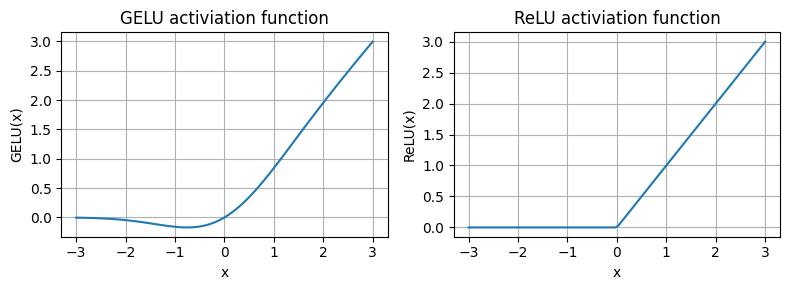

In [13]:
x = torch.linspace(-3, 3, 100) # samples 100 data pts in range -3 to 3
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8,3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1,2,i)
    plt.plot(x, y)
    plt.title(f"{label} activiation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

GELU 
- is smooth, which can lead to better optimization during training. 
- has a non-zero gradient everywhere except approx `-0.75`.
- has non-zero values for `x<0`, which means it can still play a small role in learning

ReLU has a sharp corner at zero, which can sometimes make optimization harder.


### Feed Forward

In [ ]:
# TODO: Refactor so it takes actual args intead of cfg
# This would be consistent with our other modules
# and keeps untyped cfg dict at outermost interface, only
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [15]:
ffn = FeedForward(GPT_CONFIG_124M)
samples = 2 # batch size
tokens = 3
x = torch.rand(samples, tokens, GPT_CONFIG_124M["emb_dim"])
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


### Shortcut connections

Let's first build a simple DNN with shortcut connections

In [ ]:
class ExampleDNN(nn.Module):
    def __init__(self, layer_size: list[int], use_shortcut: bool):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU()),
        ])

    def forward(self, x):
        for layer in self.layers:
            out = layer(x)
            # if enabled AND applicable
            if self.use_shortcut and x.shape == out.shape:
                x = x + out
            else:
                x = out
        return x


In [17]:
layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDNN(layer_sizes, False)

In [ ]:
def print_gradients(model, x):
    output = model(x) # forward pass
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target) # compute loss

    loss.backward() # backward pass, to calculate gradients

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [19]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041071094573
layers.3.0.weight has gradient mean of 0.0013988735154271126
layers.4.0.weight has gradient mean of 0.005049645435065031


In [20]:
torch.manual_seed(123)
model_with_shortcut = ExampleDNN(layer_sizes, use_shortcut=True)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


### Transformer Block

In [ ]:
## copied from Ch3
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout: float, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            f"d_out ({d_out}) must be divisible by num_heads ({num_heads})"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.out_proj = nn.Linear(d_out, d_out) # Linear layer to combine head outputs

        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        # b is number inputs in a batch
        b, num_tokens, d_in = x.shape

        # after multiplying by weights, the shape of these is:
        # (b, num_tokens, d_out)
        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        # view() aka "reshape"
        # We can think of this as breaking up the single matrix into multiple, one per head (num_heads)
        # recall that `d_out = num_heads * head_dim`
        # after running view(), the new dimensions are: (b, num_tokens, num_heads, head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        # transpose results in shape
        # before: (b, num_tokens, num_heads, head_dim)
        #                 ->
        # after:  (b, num_heads, num_tokens, head_dim)
        queries = queries.transpose(1,2)
        keys = keys.transpose(1,2)
        values = values.transpose(1,2)

        # 1st, we called .T
        # 2nd, we called .transpose(1,2) to handle batches (idx=0)
        # now, we call   .transpose(2,3) to handle batches (idx=0) with multiple heads (idx=1)
        attn_scores = queries @ keys.transpose(2,3)

        # apply mask for causal attention
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        # normalize
        d_k = keys.shape[-1]
        attn_weights = torch.softmax(attn_scores / d_k**0.5, dim=-1)

        # dropout
        attn_weights = self.dropout(attn_weights)

        # compute context vector
        #
        # we transpose to convert from:
        # before: (b, num_heads, num_tokens, head_dim)
        #     ->
        # after: (b, num_tokens, n_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1,2)

        # combine the heads
        # before: (b, num_heads, num_tokens, head_dim)
        #     ->
        # after: (b, num_tokens, d_out)
        #                        d_out = num_tokens * head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)

        # combine the heads through a linear layer
        # this is considered optional... why?
        # TODO: appendix B for more details
        context_vec = self.out_proj(context_vec)

        return context_vec

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.layer_norm_1 = LayerNorm(cfg["emb_dim"])
        self.mha = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"],
        )
        self.dropout_1 = nn.Dropout(cfg["drop_rate"])

        self.layer_norm_2 = LayerNorm(cfg["emb_dim"])
        self.ff = FeedForward(cfg)
        self.dropout_2 = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut1 = x
        x = self.layer_norm_1(x)
        x = self.mha(x)
        x = self.dropout_1(x)
        x = x + shortcut1

        shortcut2 = x
        x = self.layer_norm_1(x)
        x = self.ff(x)
        x = self.dropout_2(x)
        x = x + shortcut2

        return x

In [ ]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
tf_block = TransformerBlock(GPT_CONFIG_124M)
output = tf_block(x)

print("Input shape", x.shape)
print("Output shape", output.shape)

Input shape torch.Size([2, 4, 768])
Output shape torch.Size([2, 4, 768])


In [ ]:
class GPTModel(nn.Module):
    def __init__(self, cfg: dict):
        super().__init__()

        ## (1) Input -> Embeddings ##
        # token embedding
        self.token_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        # positional embedding
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        # dropout
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        ## (2) Transformers ##
        # 12x transformer blocks
        self.tf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )

        ## (3) Embeddings -> Output ##
        # layer norm
        self.final_layer_norm = LayerNorm(cfg["emb_dim"])

        # linear output layer (convert back to vocab)
        self.linear_output = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, x):
        batch_size, context_length = x.shape

        # `tok_emb` should be initialized randomly, so we just need to do the lookup
        tok_embedding = self.token_emb(x)
        # `pos_emb` should be initialized based on ordered position
        # TODO: what does it mean that we call this during the forward() step?
        #       intuitively, I think of pos_emb as initialized at start and then updated at each step
        pos_embedding = self.pos_emb(torch.arange(context_length, device=x.device))
        x = tok_embedding + pos_embedding
        x = self.drop_emb(x)


        x = self.tf_blocks(x)

        x = self.final_layer_norm(x)
        logits = self.linear_output(x)

        return logits

In [25]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4223, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [26]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 163009536


In [27]:
print("Token embedding layer shape:", model.token_emb.weight.shape)
print("Output layer shape:", model.linear_output.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [28]:
total_params_gpt = total_params - sum(p.numel() for p in model.linear_output.parameters())
print(f"GPT2 params =", total_params_gpt)

GPT2 params = 124412160


**Weight Tying**

Why the diference between 163M total parameters above vs 124M in the GPT model name?

The original GPT-2 model re-used the same weights between the Token Embedding (Vocab -> Token Embed) and Output Layer (Token Embed -> Vocab).

This is called "Weight tying", and it reduces the memory footprint by reducing the number of weights which are trained.
However, it has been found to improve performance if we *don't* use weight tying, so modern models no longer use this approach.

p.s. We'll revisit this concept in Ch6 when we use pretrained weights from OpenAI, since we'll want to fully reproduce their architecture.

_Ex 4.1: Calculate and compare the number of parameters that are contained in the feed forward module and those that are contained in the multi-head attention module._

In [29]:
get_param_count = lambda model: sum(p.numel() for p in model.parameters())

example_tf = TransformerBlock(GPT_CONFIG_124M)
print(f"Feed forward module params: {get_param_count(example_tf.ff):,}")
print(f"Multi-head attention module params: {get_param_count(example_tf.mha):,}")

Feed forward module params: 4,722,432
Multi-head attention module params: 2,360,064


Let's also compute the memory requirements of the 163M parameters in our model.
Assuming 4Kb per float...

In [30]:
bytes_per_float = 4 # 32-bit float
total_bytes = total_params * bytes_per_float
total_mb = total_bytes / (1024 * 1024)
print(f"Memory footprint of {total_params:,} parameter model: {total_mb:.2f} Mb")

Memory footprint of 163,009,536 parameter model: 621.83 Mb


_Exercise 4.2 Initializing larger GPT models_

In [ ]:
GPT_CONFIG_MEDIUM = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 1024,
    "n_heads": 16, # attention heads
    "n_layers": 24, # transformer layers
    "drop_rate": 0.1,
    "qkv_bias": False,
}

GPT_CONFIG_LARGE = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 1280,
    "n_heads": 20, # attention heads
    "n_layers": 36, # transformer layers
    "drop_rate": 0.1,
    "qkv_bias": False,
}

GPT_CONFIG_XLARGE = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 1600,
    "n_heads": 25, # attention heads
    "n_layers": 48, # transformer layers
    "drop_rate": 0.1,
    "qkv_bias": False,
}

In [32]:
gpt_m = GPTModel(GPT_CONFIG_MEDIUM)
gpt_l = GPTModel(GPT_CONFIG_LARGE)
gpt_xl = GPTModel(GPT_CONFIG_XLARGE)

print(f"GPT M  param count = {get_param_count(gpt_m):,}")
print(f"GPT L  param count = {get_param_count(gpt_l):,}")
print(f"GPT XL param count = {get_param_count(gpt_xl):,}")

GPT M  param count = 406,212,608
GPT L  param count = 838,220,800
GPT XL param count = 1,637,792,000


### Generating text

In [ ]:
def generate_text_simple(model, token_ids, max_new_tokens, context_size):
    for i in range(max_new_tokens):
        # all samples in batch .. most-recent `<= context_size` tokens
        x = token_ids[:, -context_size:]
        with torch.no_grad(): # during inference, we don't need backprop
            logits = model(x)

        token = next_token_id(logits)
        print("token_ids", token_ids)
        print("token_ids.shape", token_ids.shape)

        print("token", token)
        print("token.shape", token.shape)
        print("")
        token_ids = torch.cat((token_ids, token), dim=1)

    return token_ids

def next_token_id(batch_logits):
    """ Given batched model output,
        return next token's id  """
    # for each sample in batch, select logits for last token
    last_token_logits = batch_logits[:, -1, :]

    # softmax to get probabilities
    probas = torch.softmax(last_token_logits, dim=-1)

    # argmax to choose most likely probability
    token_id = torch.argmax(probas, dim=-1, keepdim=True)
    return token_id

    # lookup corresponding token ID, convert to text
    # return tokenizer.decode(token_id)

In [34]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) # unsqueeze adds batch dimension
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [35]:
model.eval() # disables dropout layers. allows proper inference()
out = generate_text_simple(model, encoded_tensor, 6, GPT_CONFIG_124M["context_length"])
print("Output:", out)
print("Output length:", len(out[0]))

token_ids tensor([[15496,    11,   314,   716]])
token_ids.shape torch.Size([1, 4])
token tensor([[27018]])
token.shape torch.Size([1, 1])

token_ids tensor([[15496,    11,   314,   716, 27018]])
token_ids.shape torch.Size([1, 5])
token tensor([[24086]])
token.shape torch.Size([1, 1])

token_ids tensor([[15496,    11,   314,   716, 27018, 24086]])
token_ids.shape torch.Size([1, 6])
token tensor([[47843]])
token.shape torch.Size([1, 1])

token_ids tensor([[15496,    11,   314,   716, 27018, 24086, 47843]])
token_ids.shape torch.Size([1, 7])
token tensor([[30961]])
token.shape torch.Size([1, 1])

token_ids tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961]])
token_ids.shape torch.Size([1, 8])
token tensor([[42348]])
token.shape torch.Size([1, 1])

token_ids tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348]])
token_ids.shape torch.Size([1, 9])
token tensor([[7267]])
token.shape torch.Size([1, 1])

Output: tensor([[15496,    11,   314,   716, 27018, 2408

In [36]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


The output isn't meaningful because we haven't trained the model! 
So that's our next task in Ch 5.


_Exercise 4.3 Using separate dropout parameters_

-> Skipping, since seems straightforward via refactoring config and how it gets passed to model components. If we plan to use it later, can do so.